<a href="https://colab.research.google.com/github/astrapi69/DroidBallet/blob/master/MLG_D7_LC4_Customer_Segmentation_Clustering_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='Q0'></a>
<center><a target="_blank" href="https://academy.constructor.org/"><img src="https://jobtracker.ai/static/media/constructor_academy_colour.b86fa87f.png" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____

<center> <h1> Unsupervised Learning Case-Study: Customer Segmentation (Live Coding) </h1> </center>

<p style="margin-bottom:1cm;"></p>

_____

<center>Constructor Academy, 2024</center>




The focus of this live coding notebook is for you to understand a real-world application of clustering - customer segmentation. The idea is to understand which customers are showcasing similar behavior based on their purchasing patterns from wine offer campaigns and then cluster them together. These 'people clusters' can then be targeted with specific advertising, campaigns etc.

# Case Study: Customer Segmentation (Live Coding)

## Load Dependencies

In [ ]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

## Data Understanding

The dataset contains information on two major aspects:

- Marketing newsletters/e-mail campaigns (e-mail offers sent to customers)
- Transaction level data from customers

The transactional data shows which offer customers responded to, and what the customer ended up buying.

The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

We see that the first dataset below contains information about each marketing offer regarding wine offerings such as:

- the month it is in effect
- several attributes about the wine including:
    + the variety
    + the minimum quantity
    + discount
    + country of origin
    


In [ ]:
orig_url = "https://docs.google.com/spreadsheets/d/1mlXah6ADb88FI6bL0pIQap0gxD7IoimT/edit?usp=sharing"
file_id = orig_url.split('/')[-2]
data_path='https://drive.google.com/uc?export=download&id=' + file_id
df_offers = pd.read_excel(data_path, sheet_name=0)

# subset data to get useful features
df_offers = df_offers.iloc[:, :6]
df_offers.columns = ["offer_id", "campaign", "wine_variety", "min_qty", "discount", "origin"]
df_offers.head(15)



/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,offer_id,campaign,wine_variety,min_qty,discount,origin
0,1,January,Malbec,72,56,France
1,2,January,Pinot Noir,72,17,France
2,3,February,Espumante,144,32,Oregon
3,4,February,Champagne,72,48,France
4,5,February,Cabernet Sauvignon,144,44,New Zealand
5,6,March,Prosecco,144,86,Chile
6,7,March,Prosecco,6,40,Australia
7,8,March,Espumante,6,45,South Africa
8,9,April,Chardonnay,144,57,Chile
9,10,April,Prosecco,72,52,California


The second dataset below in the second worksheet contains transactional data i.e., which offer each customer responded to and ended up buying it

In [ ]:
orig_url = "https://docs.google.com/spreadsheets/d/1mlXah6ADb88FI6bL0pIQap0gxD7IoimT/edit?usp=sharing"
file_id = orig_url.split('/')[-2]
data_path='https://drive.google.com/uc?export=download&id=' + file_id
df_transactions = pd.read_excel(data_path, sheet_name=1)

df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['frequency'] = 1
df_transactions.head(15)

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,frequency
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1
5,Williams,18,1
6,Williams,22,1
7,Williams,31,1
8,Brown,7,1
9,Brown,29,1


It is evident a customer could have purchased multiple wine offers based on the above data, but one offer is purchased only once per customer

## Data Preparation

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer to purchase it.

We start by create a dataframe which is a merged dataframe of our offers and transactions dataframes.

In [ ]:
df_merged = df_offers.merge(df_transactions, how='left', on='offer_id')
df_merged.head(20)

,offer_id,campaign,wine_variety,min_qty,discount,origin,customer_name,frequency
0,1,January,Malbec,72,56,France,Thomas,1
1,1,January,Malbec,72,56,France,Jackson,1
2,1,January,Malbec,72,56,France,Mitchell,1
3,1,January,Malbec,72,56,France,Peterson,1
4,1,January,Malbec,72,56,France,Wood,1
5,1,January,Malbec,72,56,France,Price,1
6,1,January,Malbec,72,56,France,Foster,1
7,1,January,Malbec,72,56,France,Sanders,1
8,1,January,Malbec,72,56,France,Butler,1
9,1,January,Malbec,72,56,France,Fisher,1


In [ ]:
df_merged.shape

(324, 8)

Now we create a pivot table which will form the base of our featureset, where each row has the following columns
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure we also deal with any weird values such as `NaN`.</p>
</div>

In [ ]:
pivot = df_merged.pivot_table(index=['customer_name'], values=['frequency'], columns=['offer_id'], fill_value=0)
pivot

frequency                             ...                       \
offer_id             1  2  3  4  5  6  7  8  9  10  ... 23 24 25 26 27 28 29   
customer_name                                       ...                        
Adams                 0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  1   
Allen                 0  0  0  0  0  0  0  0  1  0  ...  0  0  0  0  1  0  0   
Anderson              0  0  0  0  0  0  0  0  0  0  ...  0  1  0  1  0  0  0   
Bailey                0  0  0  0  0  0  1  0  0  0  ...  0  0  0  0  0  0  0   
Baker                 0  0  0  0  0  0  1  0  0  1  ...  0  0  0  0  0  0  0   
...                 ... .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. ..   
Williams              0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0   
Wilson                0  0  0  0  0  0  0  1  0  0  ...  0  0  0  0  0  0  0   
Wood                  1  0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0  0  0   
Wright                0  0  0  1  0  1  0  0  0  0  ...  0  0  0  0  1  0  0   
Young                 0  0  0  0  0  1  0  0  1  0  ...  0  0  0  0  0  0  0   

                        
offer_id      30 31 32  
customer_name           
Adams          1  0  0  
Allen          0  0  0  
Anderson       0  0  0  
Bailey         1  0  0  
Baker          0  1  0  
...           .. .. ..  
Williams       0  1  0  
Wilson         1  0  0  
Wood           0  1  0  
Wright         0  0  0  
Young          0  1  1  

[100 rows x 32 columns]

This tells us that we have a total of a 100 customers (rows) and 32 wine offerings (columns \ features). We now convert it into a numpy array for easy use and integration with clustering models below.

In [ ]:
X = pivot.values
X

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

In [ ]:
X.shape

(100, 32)

## Segmentation with K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in.

True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K.

The reason being for K-means clustering, __we need to find the optimal value of K__

We will cover the two popular methods below:

- the Elbow method
- the Silhouette method

Since we are working with a real-world dataset, we should not expect to find a very clear and easy solution.

### Method 1: Choosing the optimal K in K-means: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned.

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$.

_The elbow point is the point (value of K) at which the plot has a sharp descent and then starts descending much more slowly after that._

#### Plotting SS errors based on K

Let's try different values of K in K-means clustering and plot K vs the error.

In [ ]:
from sklearn.cluster import KMeans

ss = []
cluster_ranges = range(2, 11)

for K in cluster_ranges:
    # fit a k-means model
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=1000, max_iter=10000)
    kmeans.fit_predict(X)
    # stores the ss errors.
    ss.append(kmeans.inertia_)

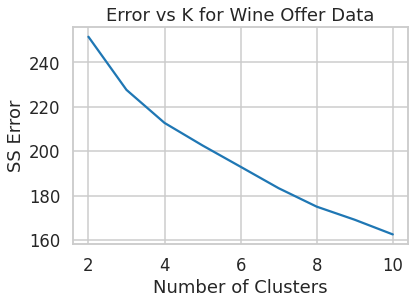

In [ ]:
ax = sns.lineplot(x=cluster_ranges, y=ss)
ax.set_title("Error vs K for Wine Offer Data")
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('SS Error');

There is a change in rate at 3 and again at 5. These changes are very small and there is no clear sharp drop or elbow in this curve.

__Let's choose 3 for now as the number of optimal clusters.__

#### What challenges did you experience using the Elbow method to pick 𝐾?
__A:__  There is no clear elbow, just a gentle curve with several subtle changes in slope of the plot of SS vs K.

---

### Method 2: Choosing the optimal K in K-means: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters.

This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$.

The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*.

The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap.

Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

__Important Note:__ On real-world datasets you might have lower values of silhouette scores due to noise and overlaps among data points.

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

Using the documentation for the `silhouette_score` function above, we will do the following two things:

- Construct a series of silhouette plots like the ones in the article linked above.
- Also compute the average silhouette score for each $K$ and plot it.

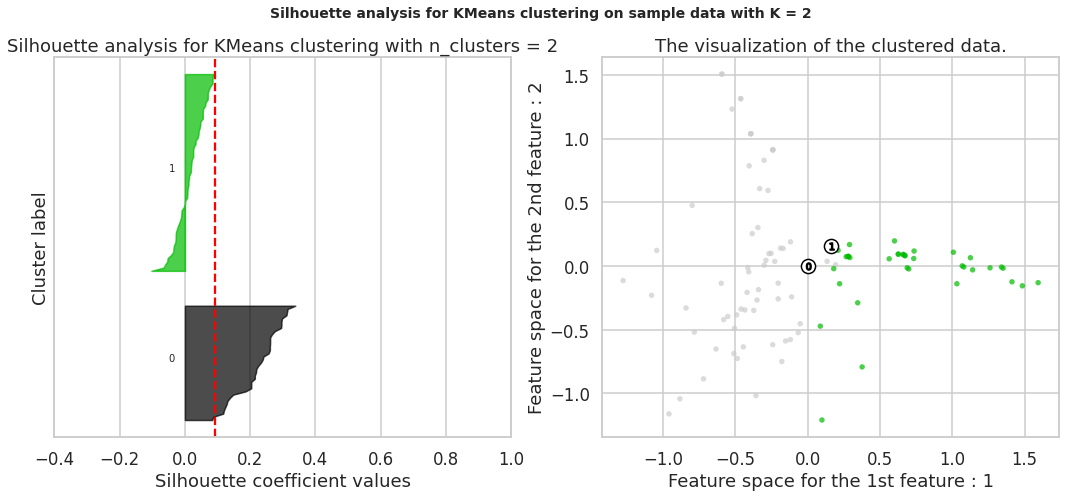

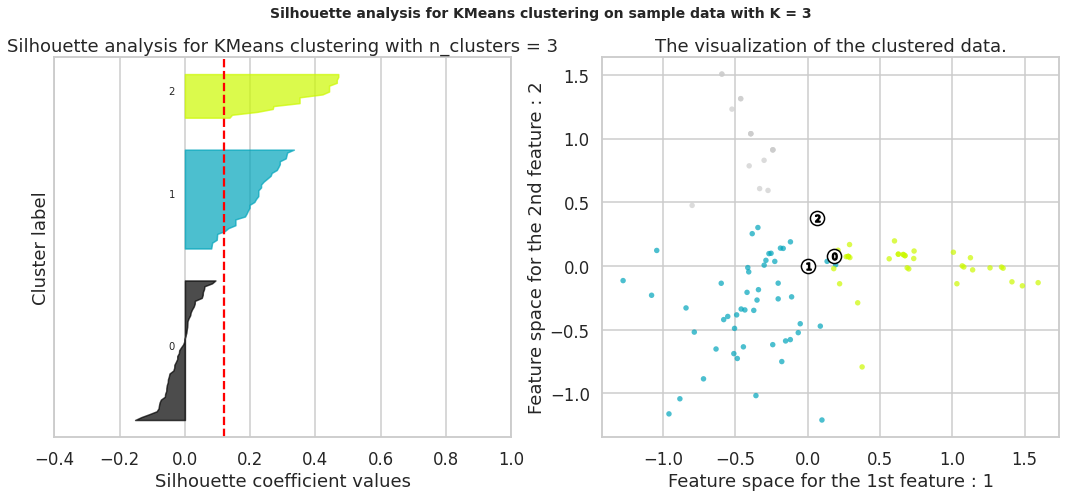

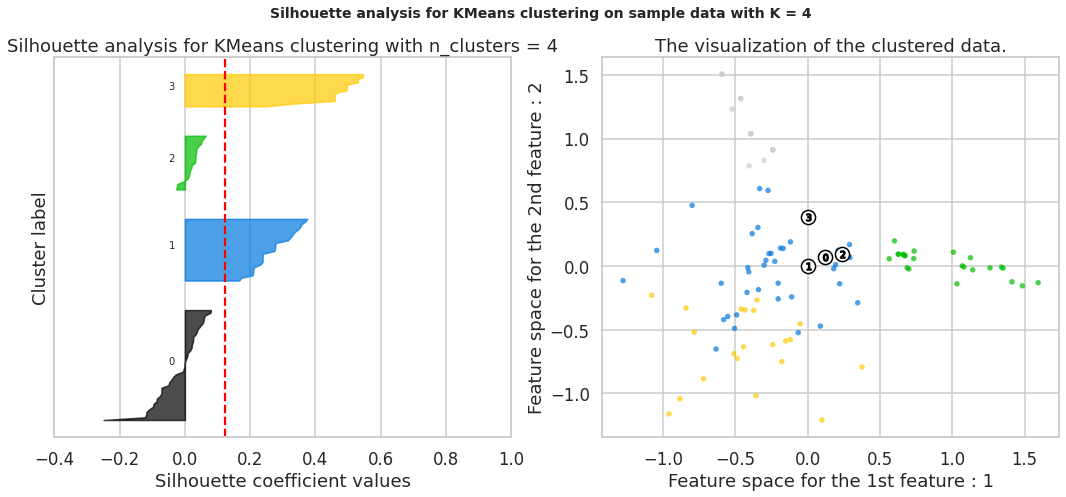

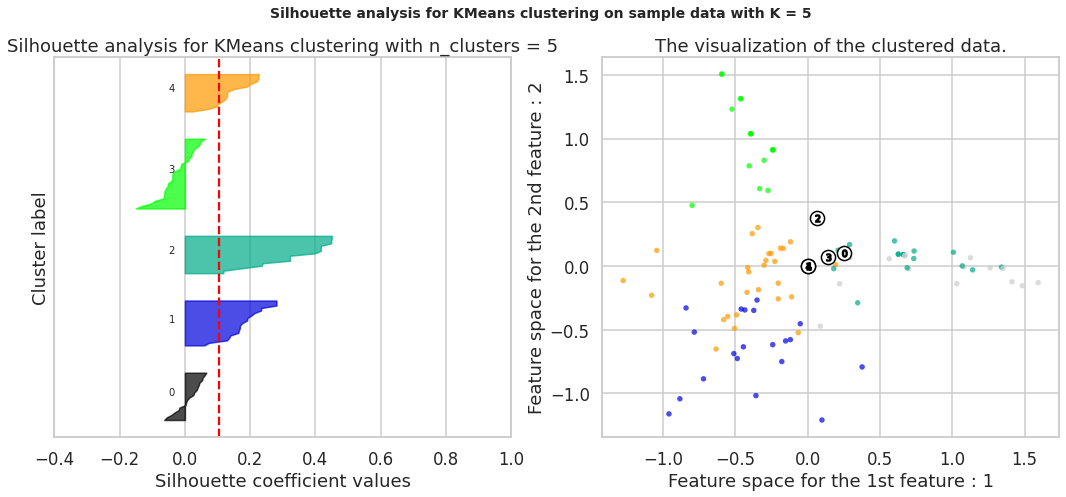

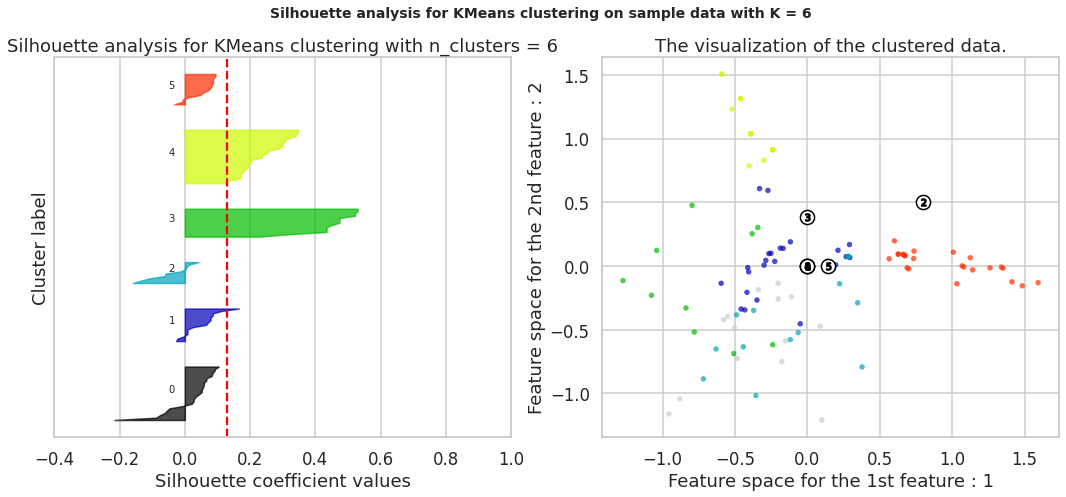

In [ ]:
# Code adapted from scikit-learn documentation example.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import numpy as np

avg_silhouette_scores = []
cluster_ranges = range(2, 7)

# Get rid of warning of too many plots open
plt.rcParams.update({'figure.max_open_warning': 0})

for K in cluster_ranges:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax.set_xlim([-.4, 1])
    # The (K+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    kmeans_model = KMeans(n_clusters=K, random_state=42, n_init=1000, max_iter=10000)
    cluster_labels = kmeans_model.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = (silhouette_score(X, cluster_labels))
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"Silhouette analysis for KMeans clustering with n_clusters = {K}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / K)
    # to visualize the actual data in a continuous space we use PCA
    pca = PCA(n_components=2).fit(X)
    data2D = pca.transform(X)
    ax2.scatter(data2D[:, 0], data2D[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans_model.cluster_centers_
    # Draw white circles at cluster centers


    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')


    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel(f"Feature space for the 1st feature : {pivot.columns[0][1]}")
    ax2.set_ylabel(f"Feature space for the 2nd feature : {pivot.columns[1][1]}")

    plt.suptitle(
        (
            f"Silhouette analysis for KMeans clustering on sample data with K = {K}"
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")

plt.show()

Now plot average Silhouette Score for each value of K.

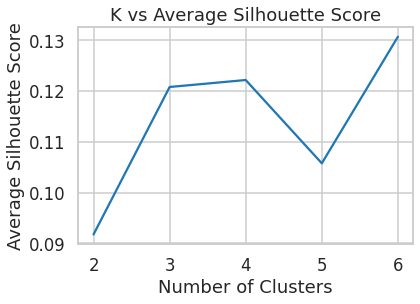

In [ ]:
ax = sns.lineplot(x=cluster_ranges, y=avg_silhouette_scores)
ax.set_title('K vs Average Silhouette Score')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Silhouette Score');

In [ ]:
avg_silhouette_scores

[0.09174871508750351,
 0.12078917343046144,
 0.12216021959991094,
 0.10575663913130803,
 0.13068542222153387]

#### What 𝐾 does the plot suggest we should choose? Does it differ from what we found using the Elbow method?
__A:__ This plot shows local peaks at K=3 and K=5, but the value of the Silhouette Score indicates that no substantial structure has been found.  

However as mentioned before this is often the case with real-world noisy datasets. __Hence we choose the optimal number of customer segments to be 3__

---

### Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

First create the PCA features. Then try K=3 based on our silhouette analysis

In [ ]:
from sklearn.decomposition import PCA

# First calculate top two PCA features.
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)
x = pca_features[:,0]
y = pca_features[:,1]

K=3

kmeans = KMeans(n_clusters=K, random_state=42, n_init=1000, max_iter=10000)
cl_labels = kmeans.fit_predict(X)
df_pca_features = pd.DataFrame({'cluster_id': cl_labels,
                                'pc_1':x,
                                'pc_2':y})
df_pca_features

,cluster_id,pc_1,pc_2
0,1,1.007580,0.108215
1,0,-0.287539,0.044715
2,2,-0.392032,1.038391
3,1,0.699477,-0.022542
4,0,0.088183,-0.471695
...,...,...,...
95,0,-0.151666,-0.587844
96,1,0.688224,-0.013688
97,0,-0.551215,-0.395670
98,0,-0.489805,-0.383307


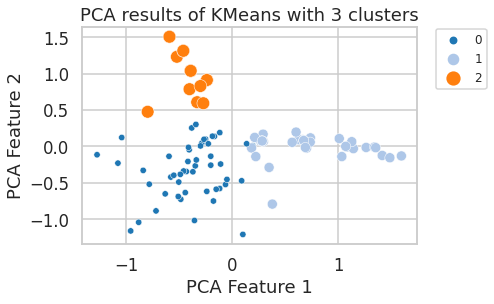

In [ ]:
ax = sns.scatterplot(x='pc_1', y='pc_2',
                hue='cluster_id',
                size='cluster_id',
                data=df_pca_features,
                palette='tab20',
                legend='full')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('PCA results of KMeans with ' + str(K) + ' clusters')
ax.legend(bbox_to_anchor=(1.04,1.02), loc='upper left', fontsize='large');

The clusters appear to overlap a fair amount but are also distinct and well-formed.

This is not surprising given the Silhouette Score was low but it's still probably the best out of all other values of K we observed earlier.

## Data Story & Insights

Can we get some meaningful insights from the end results of clustering? Since building a model is all good but pointless unless it can add some business value.

### Data Merging

Merging clusters with original customer and offer data

In [ ]:
cl_labels

array([1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 1, 1,
       0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 2,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int32)

In [ ]:
customer_segments = pd.DataFrame({
    'customer_name': pivot.index.tolist(),
    'Cluster': cl_labels
})

customer_segments.head(10)

,customer_name,Cluster
0,Adams,1
1,Allen,0
2,Anderson,2
3,Bailey,1
4,Baker,0
5,Barnes,0
6,Bell,2
7,Bennett,1
8,Brooks,0
9,Brown,1


In [ ]:
df_merged.head(10)

,offer_id,campaign,wine_variety,min_qty,discount,origin,customer_name,frequency
0,1,January,Malbec,72,56,France,Thomas,1
1,1,January,Malbec,72,56,France,Jackson,1
2,1,January,Malbec,72,56,France,Mitchell,1
3,1,January,Malbec,72,56,France,Peterson,1
4,1,January,Malbec,72,56,France,Wood,1
5,1,January,Malbec,72,56,France,Price,1
6,1,January,Malbec,72,56,France,Foster,1
7,1,January,Malbec,72,56,France,Sanders,1
8,1,January,Malbec,72,56,France,Butler,1
9,1,January,Malbec,72,56,France,Fisher,1


In [ ]:
df_cluster_merged = df_merged.merge(customer_segments, on='customer_name')
df_cluster_merged.head(10)

,offer_id,campaign,wine_variety,min_qty,discount,origin,customer_name,frequency,Cluster
0,1,January,Malbec,72,56,France,Thomas,1,0
1,4,February,Champagne,72,48,France,Thomas,1,0
2,9,April,Chardonnay,144,57,Chile,Thomas,1,0
3,11,May,Champagne,72,85,France,Thomas,1,0
4,14,June,Merlot,72,64,Chile,Thomas,1,0
5,26,October,Pinot Noir,144,83,Australia,Thomas,1,0
6,1,January,Malbec,72,56,France,Jackson,1,0
7,2,January,Pinot Noir,72,17,France,Jackson,1,0
8,11,May,Champagne,72,85,France,Jackson,1,0
9,15,June,Cabernet Sauvignon,144,19,Italy,Jackson,1,0


### Insights

#### Analyzing which customer segments bought the most wine based on months

In [ ]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                           'September', 'October', 'November', 'December']
res = pd.crosstab(df_cluster_merged.Cluster, df_cluster_merged.campaign)
res = res[months]
res

campaign,January,February,March,April,May,June,July,August,September,October,November,December
Cluster,,,,,,,,,,,,
0,13,20,17,14,16,19,5,28,4,16,6,27
1,0,2,34,2,7,0,14,3,0,1,17,16
2,7,0,0,1,1,1,7,0,13,13,0,0


In [ ]:
from matplotlib import cm

custom_colors = cm.get_cmap('tab20', 12)

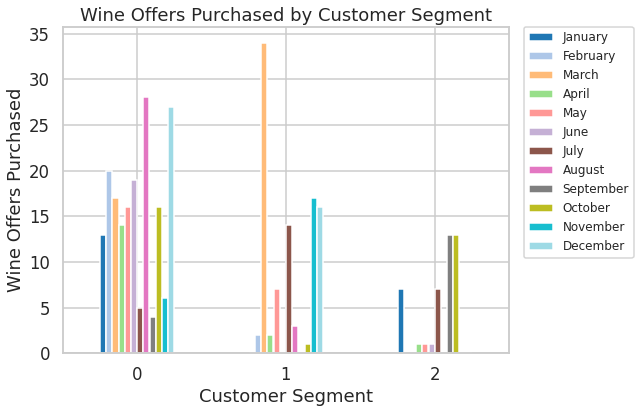

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

res.plot(kind='bar', ax=ax, cmap=custom_colors)
ax.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
plt.xlabel('Customer Segment')
plt.xticks(rotation=0)
plt.ylabel('Wine Offers Purchased')
plt.title('Wine Offers Purchased by Customer Segment');

Let's apply some filtering to make the most purchases more prominent

In [ ]:
res[res <= 15] = 0
res

campaign,January,February,March,April,May,June,July,August,September,October,November,December
Cluster,,,,,,,,,,,,
0,0,20,17,0,16,19,0,28,0,16,0,27
1,0,0,34,0,0,0,0,0,0,0,17,16
2,0,0,0,0,0,0,0,0,0,0,0,0


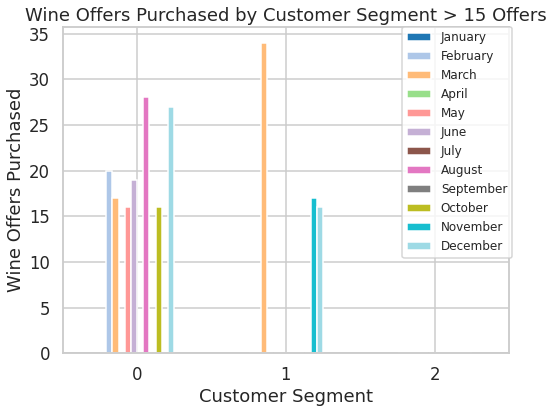

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

res.plot(kind='bar', ax=ax, cmap=custom_colors)
ax.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
plt.xlabel('Customer Segment')
plt.xticks(rotation=0)
plt.ylabel('Wine Offers Purchased')
plt.title('Wine Offers Purchased by Customer Segment > 15 Offers');

This tells us that:

- Customers in segment 0 bought wine throughout the year, with the highest order frequency in March, August and December.
- Customers in segment 1 bought wine mostly in March, November and December
- For customers in segment 2, there was no one month with more than 15 orders.

Maybe we can offer them some special offers based on when they ordered wine before?

#### Analyzing which customer segments bought the most wine based on wine type

In [ ]:
res = pd.crosstab(df_cluster_merged.Cluster, df_cluster_merged.wine_variety)
res

wine_variety,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
Cluster,,,,,,,,,
0,31,75,14,8,15,13,1,7,21
1,1,5,0,32,16,6,16,0,20
2,0,1,1,0,1,1,0,37,2


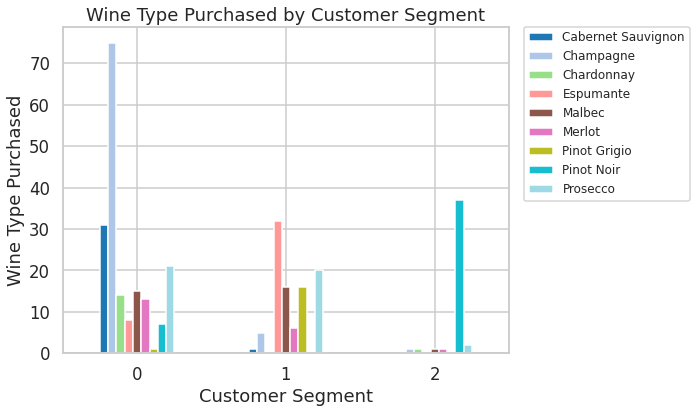

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

res.plot(kind='bar', ax=ax, cmap=custom_colors)
ax.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
plt.xlabel('Customer Segment')
plt.xticks(rotation=0)
plt.ylabel('Wine Type Purchased')
plt.title('Wine Type Purchased by Customer Segment');

This tells us that:

- Customers in segment 0 bought mostly Champagne, Cabernet Sauvignon and Prosecco.
- Customers in segment 1 bought mostly Espumante.
- Customers in segment 2 showed a clear preference for Pinot Noir.

Maybe we can offer customers in each segment a discount based on their preferences?

#### Analyzing which customer segments bought the most wine based on quantity

In [ ]:
res = pd.crosstab(df_cluster_merged.Cluster, df_cluster_merged.min_qty)
res

min_qty,6,12,72,144
Cluster,,,,
0,14,11,118,42
1,84,4,5,3
2,12,7,11,13


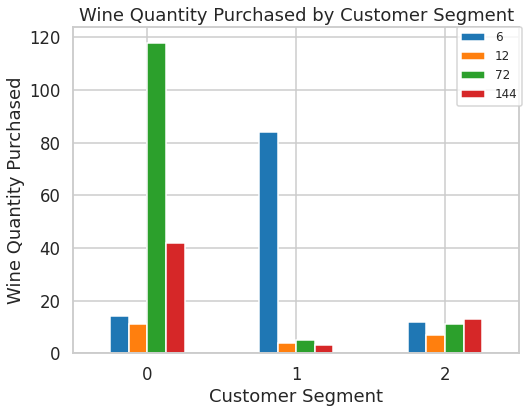

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

res.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1.02), fontsize='large')
plt.xlabel('Customer Segment')
plt.xticks(rotation=0)
plt.ylabel('Wine Quantity Purchased')
plt.title('Wine Quantity Purchased by Customer Segment');

While we don't have the insight on what unit the quantity is, we can probably assume it is mentioned in glasses here.

This tells us that:

- Customers in segment 0 placed many orders for the 72-glass quantity and also quite a few for the 144-glass quantity.
- Customers in segment 1 bought 6 glasses quantity the most. They clearly prefer smaller quantities.
- Customers in segment 2 made purchases in all quantities.

Maybe the focus should be on customers of segment 0 as they are the big spenders?

## Clustering Algorithms in Scikit-learn

<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html